# Load dependencies

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import pandas as pd
from scipy.stats import pearsonr
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from matplotlib import pyplot as plt
import seaborn as sns
sns.set()

In [2]:
device = torch.device('cuda')

In [3]:
#### from https://github.com/gngdb/pytorch-pca/tree/main ####
def svd_flip(u, v):
    # columns of u, rows of v
    max_abs_cols = torch.argmax(torch.abs(u), 0)
    i = torch.arange(u.shape[1]).to(u.device)
    signs = torch.sign(u[max_abs_cols, i])
    u *= signs
    v *= signs.view(-1, 1)
    return u, v

class TorchPCA(nn.Module):
    def __init__(self, n_components):
        super().__init__()
        self.n_components = n_components

    #@torch.no_grad()
    def fit(self, X):
        n, d = X.size()
        if self.n_components is not None:
            d = min(self.n_components, d)
        self.register_buffer("mean_", X.mean(0, keepdim=True))
        Z = X - self.mean_ # center
        U, S, Vh = torch.linalg.svd(Z, full_matrices=False)
        Vt = Vh
        U, Vt = svd_flip(U, Vt)
        self.register_buffer("components_", Vt[:d])
        return self

    def forward(self, X):
        return self.transform(X)

    def transform(self, X):
        assert hasattr(self, "components_"), "PCA must be fit before use."
        return torch.matmul(X - self.mean_, self.components_.t())

    def fit_transform(self, X):
        self.fit(X)
        return self.transform(X)

    def inverse_transform(self, Y):
        assert hasattr(self, "components_"), "PCA must be fit before use."
        return torch.matmul(Y, self.components_) + self.mean_

In [4]:
def rank_tensor(x):
    """
    Returns the ranks of the elements in the input tensor x.
    """
    tmp = x.argsort()
    ranks = torch.zeros_like(tmp)
    ranks[tmp] = torch.arange(len(x), device=x.device)
    return ranks

def spearman_corr(x, y):
    """
    Calculates the differentiable Spearman correlation between two tensors x and y.
    """
    assert x.shape == y.shape, "Input tensors must have the same shape"
    
    n = x.size(0)

    # Rank the tensors
    x_rank = rank_tensor(x).float()
    y_rank = rank_tensor(y).float()
    
    # Compute the covariance between the ranks
    x_rank_mean = x_rank.mean()
    y_rank_mean = y_rank.mean()
    
    cov_xy = ((x_rank - x_rank_mean) * (y_rank - y_rank_mean)).mean()
    
    # Compute the standard deviations of the ranks
    std_x_rank = x_rank.std()
    std_y_rank = y_rank.std()
    
    # Compute the Spearman correlation
    spearman_corr = cov_xy / (std_x_rank * std_y_rank)
    
    return spearman_corr


# Load data

In [5]:
X_A = pd.read_csv('X_Govaere.csv',index_col=0)
X_B = pd.read_csv('X_Kostrzewski_grouped.csv',index_col=0)
Y_A = pd.read_csv('Y_Govaere.csv',index_col=0)
Wh = pd.read_csv('../results/Wh_govaere.csv',index_col=0)
W_extra = pd.read_csv('../results/Wm_kostrzewski_extra.csv',index_col=0)
lean_control_ind = 'high_lean_FALSE_FALSE_FALSE_FALSE' # in the pair that explains most of the variance it is the control
fatty_control_ind = 'high_fat_FALSE_FALSE_FALSE_FALSE'

In [6]:
# get total variance of X_A
varA = np.var(X_A,axis=0).sum()
print(varA)

3569.181344230154


# Get PCA loadings

In [7]:
# initialize a PCA object with the largest value of n_components you can
pca = PCA()
# fit your PCA object to your data
pca.fit(X_B)
# transform your data into PCA space
Z_B = pca.transform(X_B)

Text(0.5, 1.0, 'in-vitro model PC space')

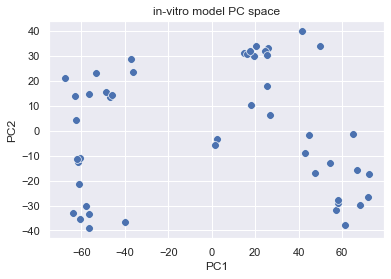

In [8]:
pca_data = pd.DataFrame(data={'PC1':Z_B[:,0], 'PC2':Z_B[:,1]})
# pca_data = pd.concat([pca_data,pd.DataFrame(data={'PC1':Z_A_B[:,0], 'PC2':Z_A_B[:,1]})])
# pca_data['dataset'] = ['in-vitro model' for i in range(Z_B.shape[0])] + ['humans' for i in range(Z_A_B.shape[0])]
# plot our PCA transformed data using sns.scatterplot() (set hue = target)
sns.scatterplot(data = pca_data , x = 'PC1',y = 'PC2', s =60 , palette= 'icefire')
plt.title('in-vitro model PC space')

In [9]:
loadings = pca.components_
print(loadings.shape)

(48, 26001)


In [10]:
Z_A_B = np.dot(X_A,loadings.T)
varAB = np.var(Z_A_B,axis=0).sum()
print('The explained variance of the human data in the PC-space of liver chip is {:.2f} %'.format(100*varAB/varA))

The explained variance of the human data in the PC-space of liver chip is 32.44 %


# Initialize perturbation as a small random dX

In [12]:
XB_lean = X_B.loc[lean_control_ind,:].values.reshape(1,X_B.shape[1])
XB_fatty = X_B.loc[fatty_control_ind,:].values.reshape(1,X_B.shape[1])
dim_init = XB_lean.shape[1]
dX_lean = np.random.normal(X_B.mean(0).values,X_B.std(0).values,size=(1,dim_init))
dX_lean = torch.tensor(dX_lean).float().to(device)
# dX_fatty = np.random.normal(X_B.mean(0).values,X_B.std(0).values,size=(1,XB_fatty.shape[1]))
# dX_fatty = torch.tensor(dX_fatty).float().to(device)
# Input_fatty = torch.nn.Parameter(dX_fatty, requires_grad = True)
# Input_fatty.retain_grad()
Input_lean = torch.nn.Parameter(dX_lean, requires_grad = True)
Input_lean.retain_grad()
# optimizer = torch.optim.Adam([Input_lean,Input_fatty],lr= 0.1,weight_decay=0)
optimizer = torch.optim.Adam([Input_lean],lr= 0.1,weight_decay=0)
# scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
#                                             step_size=150,
#                                             gamma=0.8)
XB_lean = torch.tensor(XB_lean).float().to(device)
XB_lean = torch.mean(XB_lean,0,keepdim = True)
# XB_fatty = torch.tensor(XB_fatty).float().to(device)
# XB_fatty = torch.mean(XB_fatty,0,keepdim = True)
XB = torch.tensor(X_B.values).float().to(device)
XA = torch.tensor(X_A.values).float().to(device)
W_A = torch.tensor(Wh.values).float().to(device)
W_B_extra = torch.tensor(W_extra.values).float().to(device)

In [13]:
# print(XB_fatty.shape)
print(XB_lean.shape)

torch.Size([1, 26001])


In [19]:
df_lean = pd.DataFrame({})
# df_fatty = pd.DataFrame({})
iters = 1000
all_dx = np.zeros((30,XB.shape[1]))
for j in range(30):
    dX_lean = np.random.normal(X_B.mean(0).values,X_B.std(0).values,size=(1,dim_init))
    dX_lean = torch.tensor(dX_lean).float().to(device)
    Input_lean = torch.nn.Parameter(dX_lean, requires_grad = True)
    Input_lean.retain_grad()
    optimizer = torch.optim.Adam([Input_lean],lr= 0.1,weight_decay=0)
    torch.autograd.set_detect_anomaly(True)
    loss_all = []
    exp_var_all = []
    for i in range(iters):
        optimizer.zero_grad()
        Xstar_lean = XB_lean + Input_lean
        #Xstar_fatty = XB_fatty + Input_fatty
        #X = torch.concat((XB,Xstar_lean,Xstar_fatty),0)
        X = torch.concat((XB,Xstar_lean),0)
        U,S,V = torch.svd(X)
        #Z_A_B = torch.matmul(XA,P.T)
        Z_A_B = torch.matmul(XA,V)
        varAB = torch.var(Z_A_B,axis=0).sum()

        ## spearman loss
        #lean_spear = torch.abs(spearman_corr(Input_lean.squeeze(),W_B_extra[:,0]))
        #lean_spear = lean_spear + torch.abs(spearman_corr(Input_lean.squeeze(),W_B_extra[:,1]))
        #fatty_spear = spearman_corr(Input_fatty.squeeze(),W_B_extra[:,0]) + spearman_corr(Input_fatty.squeeze(),W_B_extra[:,1])

        loss = - varAB/varA
        loss = loss + 1e-6 * torch.sum(torch.abs(Input_lean))

        loss.backward()
        optimizer.step()
        #scheduler.step()

        exp_var = 100 * varAB/varA
        exp_var = exp_var.item()
        loss_all.append(loss.item())
        exp_var_all.append(exp_var)
        if i % 200 == 0 :
            outString = 'Sample {:.0f} Iteration={:.0f}'.format(j,i)
            outString += ', loss={:.4f}'.format(loss.item())
            outString += ', explained_variance={:.2f}%'.format(exp_var)
            print(outString)
    outString = 'Sample {:.0f} Iteration={:.0f}'.format(j,i)
    outString += ', loss={:.4f}'.format(loss.item())
    outString += ', explained_variance={:.2f}%'.format(exp_var)
    print(outString)
    plt.plot(range(iters),exp_var_all)
    all_dx[j,:] = Input_lean.detach().cpu().numpy()
    j = j +1
# lean_dx = pd.DataFrame(Input_lean.detach().cpu().numpy())
lean_dx = pd.DataFrame(np.mean(all_dx,0)).T
lean_dx.columns = X_B.columns.values
lean_dx_std = pd.DataFrame(np.std(all_dx,0)).T
lean_dx_std.columns = X_B.columns.values
df_lean = pd.concat([df_lean,lean_dx])
# fatty_dx = pd.DataFrame(Input_fatty.detach().cpu().numpy())
# fatty_dx.columns = X_B.columns.values
# df_fatty = df_fatty.append(fatty_dx)

In [20]:
# df_fatty.index = [i for i in range(XB_fatty.shape[0])]
df_lean.index = [i for i in range(XB_lean.shape[0])]

In [21]:
df_lean

,TSPAN6,TNMD,DPM1,SCYL3,C1orf112,FGR,CFH,FUCA2,GCLC,NFYA,...,DDX51,YBX2,NANOS3,ISLR,CHEK2P5,TMEM95,C1R,OR4F4,PRKACA,GOLGA6L2
0,-0.02893,-0.005145,-0.010471,0.011434,0.003978,0.089125,0.005085,-0.021882,-0.033385,0.018384,...,0.062907,0.084003,-0.000699,0.049504,0.0,0.000646,0.050825,-0.001582,0.029422,0.000939


(array([5.0000e+00, 1.2000e+01, 1.4900e+02, 2.4300e+03, 2.0011e+04,
        3.0870e+03, 2.6500e+02, 3.1000e+01, 6.0000e+00, 5.0000e+00]),
 array([-0.29467245, -0.23014489, -0.16561733, -0.10108978, -0.03656222,
         0.02796533,  0.09249289,  0.15702045,  0.221548  ,  0.28607556,
         0.35060312]),
 <BarContainer object of 10 artists>)

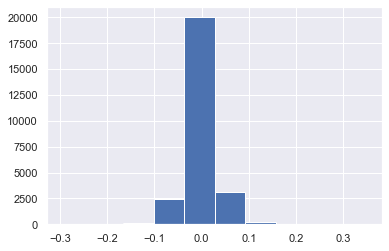

In [22]:
plt.hist(lean_dx.values.squeeze())

(array([2.1836e+04, 3.3520e+03, 6.5500e+02, 1.0400e+02, 3.5000e+01,
        8.0000e+00, 7.0000e+00, 1.0000e+00, 2.0000e+00, 1.0000e+00]),
 array([0.        , 0.29914911, 0.59829823, 0.89744734, 1.19659646,
        1.49574557, 1.79489469, 2.0940438 , 2.39319291, 2.69234203,
        2.99149114]),
 <BarContainer object of 10 artists>)

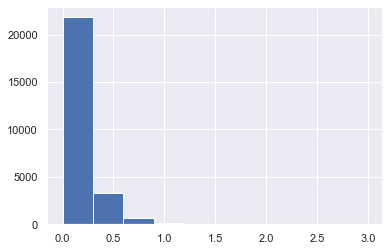

In [23]:
plt.hist(lean_dx_std.values.squeeze())

In [24]:
# df_fatty

In [25]:
df_lean.to_csv('../results/optimized_mps/dx_lean_govaere_kostrzewski_corrected.csv')
# df_fatty.to_csv('../results/optimized_mps/dx_fatty_govaere_kostrzewski.csv')

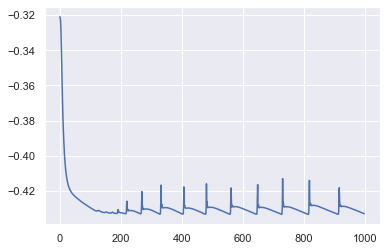

In [26]:
plt.plot(range(iters),loss_all)

In [51]:
# plt.plot(range(iters),exp_var_all)

(array([1.29204815e-04, 1.29204867e-03, 2.97171074e-03, 4.90978296e-03,
        1.77010632e-02, 9.28982711e-02, 5.12297193e-01, 2.28007759e+00,
        3.25208584e-01, 7.01582214e-02, 2.66161972e-02, 1.22744599e-02,
        5.55580703e-03, 3.10091555e-03, 2.84250706e-03, 6.46023815e-04,
        2.58409733e-04, 3.87614600e-04, 0.00000000e+00, 1.29204867e-04]),
 array([-2.27879262, -1.98112524, -1.68345797, -1.38579059, -1.0881232 ,
        -0.79045588, -0.49278852, -0.19512118,  0.10254617,  0.40021351,
         0.69788086,  0.99554819,  1.29321551,  1.5908829 ,  1.88855028,
         2.18621755,  2.48388505,  2.78155231,  3.07921958,  3.37688708,
         3.67455435]),
 <BarContainer object of 20 artists>)

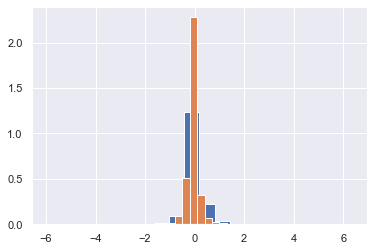

In [27]:
plt.hist(XB.detach().cpu().numpy().flatten(),20,density=True)
# plt.hist(Xstar_fatty.detach().cpu().numpy().flatten(),20,density=True)
plt.hist(Xstar_lean.detach().cpu().numpy().flatten(),20,density=True)

(array([3.57615209e-03, 2.38410139e-03, 2.38410139e-03, 1.19205070e-02,
        3.69535716e-02, 1.40661982e-01, 6.85429151e-01, 2.21125404e+00,
        6.07945855e+00, 1.77746679e+01, 2.82158400e+00, 8.58276502e-01,
        2.52714748e-01, 6.31786869e-02, 2.02648618e-02, 1.66887098e-02,
        2.38410139e-03, 4.76820279e-03, 3.57615209e-03, 2.38410139e-03]),
 array([-0.29467245, -0.26240867, -0.23014489, -0.19788111, -0.16561733,
        -0.13335356, -0.10108978, -0.068826  , -0.03656222, -0.00429844,
         0.02796533,  0.06022911,  0.09249289,  0.12475667,  0.15702045,
         0.18928422,  0.221548  ,  0.25381178,  0.28607556,  0.31833934,
         0.35060312]),
 <BarContainer object of 20 artists>)

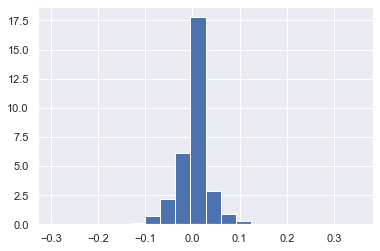

In [28]:
plt.hist(df_lean.values.flatten(),20,density=True)

In [54]:
# plt.hist(df_fatty.values.flatten(),20,density=True)

### Validate with sklearn

In [29]:
# Xstar_lean = XB_lean + Input_lean
Xstar_lean = XB_lean + torch.tensor(lean_dx.values).to(device)
# Xstar_fatty = XB_fatty + Input_fatty
# X = torch.concat((XB,Xstar_lean,Xstar_fatty),0)
X = torch.concat((XB,Xstar_lean),0)
X = X.detach().cpu().numpy()

In [30]:
lean_ind = np.where(np.isin(X_B.index.values, lean_control_ind))[0]
# fatty_ind = np.where(np.isin(X_B.index.values, fatty_control_ind))[0]

<Axes: xlabel='PC1', ylabel='PC2'>

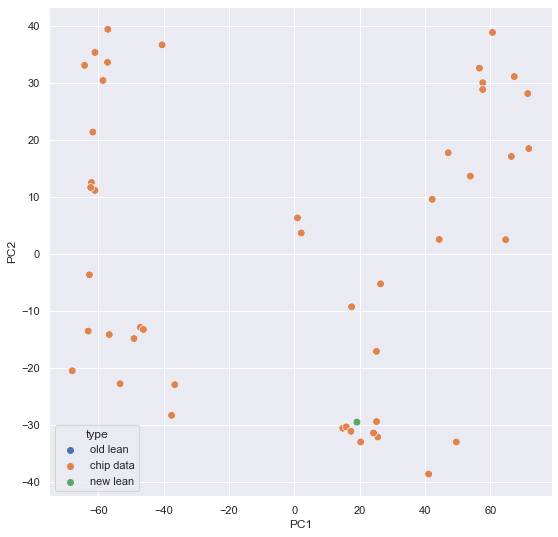

In [31]:
# initialize a PCA object with the largest value of n_components you can
pca = PCA()
# fit your PCA object to your data
pca.fit(X)
# transform your data into PCA space
Z_B = pca.transform(X)
pca_data = pd.DataFrame(data={'PC1':Z_B[:,0], 'PC2':Z_B[:,1]})
# plot our PCA transformed data using sns.scatterplot() (set hue = target)
# pca_data["type"] = ['chip data' for i in range(XB.shape[0])] + ['new lean' for i in range(XB_lean.shape[0])] + ['new fatty' for i in range(XB_fatty.shape[0])]
pca_data["type"] = ['chip data' for i in range(XB.shape[0])] + ['new lean' for i in range(XB_lean.shape[0])] 
pca_data.iloc[lean_ind,2] = 'old lean'
# pca_data.iloc[fatty_ind,2] = 'old fatty'
plt.figure(figsize=(9, 9))
sns.scatterplot(data = pca_data , x = 'PC1',y = 'PC2' , s =60 ,hue='type')

In [32]:
loadings = pca.components_
print(loadings.shape)
Z_A_B = np.dot(X_A,loadings.T)
varAB = np.var(Z_A_B,axis=0).sum()
print('The explained variance of the human data in the PC-space of liver chip is {:.2f} %'.format(100*varAB/varA))

(49, 26001)
The explained variance of the human data in the PC-space of liver chip is 43.18 %


In [28]:
# varA_filt = np.var(np.dot(np.dot(X_A,Wh),Wh.T),axis=0).sum()
# Z_A_B_filt = np.dot(np.dot(np.dot(X_A,Wh),Wh.T),loadings.T)
# varAB_filt = np.var(Z_A_B_filt,axis=0).sum()
# print('The explained variance of the human data in the PC-space of liver chip is {:.2f} %'.format(100*varAB_filt/varA_filt))

In [29]:
# varA_filt = np.var(X_A-np.dot(np.dot(X_A,Wh),Wh.T),axis=0).sum()
# Z_A_B_filt = np.dot(X_A-np.dot(np.dot(X_A,Wh),Wh.T),loadings.T)
# varAB_filt = np.var(Z_A_B_filt,axis=0).sum()
# print('The explained variance of the human data in the PC-space of liver chip is {:.2f} %'.format(100*varAB_filt/varA_filt))

### Perturb with dX all lean and fatty samples

In [33]:
XB_lean = X_B.loc[lean_control_ind,:]
# XB_fatty = X_B.loc[fatty_control_ind,:]
XB_lean = torch.tensor(XB_lean.values).float().to(device)
# XB_fatty = torch.tensor(XB_fatty.values).float().to(device)

In [34]:
Xstar_lean = XB_lean + torch.tensor(df_lean.values).to(device)
# Xstar_fatty = XB_fatty + torch.tensor(df_fatty.values).to(device)

In [35]:
df_lean = np.concatenate([XB_lean.detach().cpu().numpy().reshape(1,X_B.shape[1]),
                          Xstar_lean.detach().cpu().numpy()],0)
df_lean = pd.DataFrame(df_lean)
df_lean.columns = X_B.columns.values
df_lean.index = ['control'+str(i) for i in range(Xstar_lean.shape[0])] + ['perturbed'+str(i) for i in range(Xstar_lean.shape[0])]
df_lean = df_lean.T
df_lean.to_csv('../results/optimized_mps/pertubed_control_lean_corrected.csv')

In [69]:
# df_fatty = np.concatenate([XB_fatty.detach().cpu().numpy().reshape(1,X_B.shape[1]),
#                            Xstar_fatty.detach().cpu().numpy()],0)
# df_fatty = pd.DataFrame(df_fatty)
# df_fatty.columns = X_B.columns.values
# df_fatty.index = ['control'+str(i) for i in range(Xstar_fatty.shape[0])] + ['perturbed'+str(i) for i in range(Xstar_fatty.shape[0])]
# df_fatty = df_fatty.T
# df_fatty.to_csv('../results/optimized_mps/pertubed_control_fatty.csv')

In [36]:
# X = torch.concat((XB,Xstar_lean,Xstar_fatty),0)
X = torch.concat((XB,Xstar_lean),0)
X = X.detach().cpu().numpy()

In [37]:
lean_ind = np.where(np.isin(X_B.index.values, lean_control_ind))[0]
# fatty_ind = np.where(np.isin(X_B.index.values, fatty_control_ind))[0]

<Axes: xlabel='PC1', ylabel='PC2'>

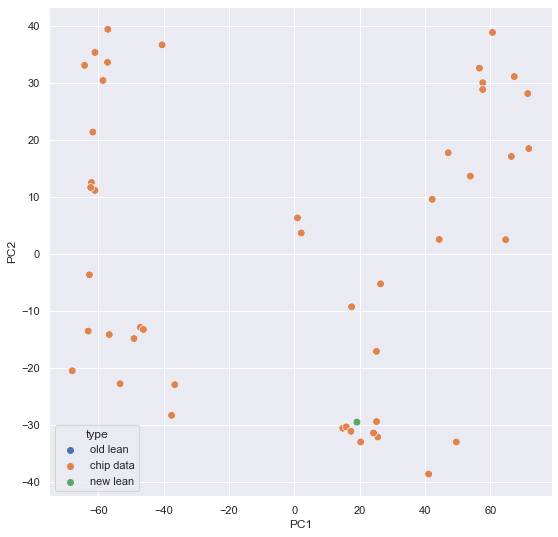

In [38]:
# initialize a PCA object with the largest value of n_components you can
pca = PCA()
# fit your PCA object to your data
pca.fit(X)
# transform your data into PCA space
Z_B = pca.transform(X)
pca_data = pd.DataFrame(data={'PC1':Z_B[:,0], 'PC2':Z_B[:,1]})
# plot our PCA transformed data using sns.scatterplot() (set hue = target)
pca_data["type"] = ['chip data' for i in range(XB.shape[0])] + ['new lean' for i in range(Xstar_lean.shape[0])] #+ ['new fatty' for i in range(Xstar_fatty.shape[0])]
pca_data.iloc[lean_ind,2] = 'old lean'
# pca_data.iloc[fatty_ind,2] = 'old fatty'
plt.figure(figsize=(9, 9))
sns.scatterplot(data = pca_data , x = 'PC1',y = 'PC2' , s =60 ,hue='type')

In [39]:
loadings = pca.components_
print(loadings.shape)
Z_A_B = np.dot(X_A,loadings.T)
varAB = np.var(Z_A_B,axis=0).sum()
print('The explained variance of the human data in the PC-space of liver chip is {:.2f} %'.format(100*varAB/varA))

(49, 26001)
The explained variance of the human data in the PC-space of liver chip is 43.18 %
